In [ ]:
!python -m spacy download "pt_core_news_sm"

In [2]:
# import psycopg2
import pandas as pd
import numpy as np
import paramiko

from pandas.io import sql as psql

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook # Beta

# from pre_processing.pre_processing import BatchProcessing

from zipfile import ZipFile
from matplotlib import pyplot as plt

tqdm_notebook.pandas()

In [26]:
with ZipFile('data/Annotated_types.zip') as zip_dir:
    df_test_dump = pd.read_csv(zip_dir.open('test_types-26-07-18.csv'))
    df_train_dump = pd.read_csv(zip_dir.open('train_types-26-07-18.csv'))
df = pd.concat([df_test_dump, df_train_dump], keys=['test', 'train'])
print('columns {}\n\n\tsize of test {}\n\tsize of train {}\n\tconcat size {}\n'
      .format(', '.join(df.columns), df_test_dump.shape, df_train_dump.shape, df.shape))

columns text, document_id, label

	size of test (3016, 3)
	size of train (7035, 3)
	concat size (10051, 3)



In [24]:
def page_split(row):
    split = row.text.split('-----------------')
    if len(split) == 1:
        split += [None]
    elif len(split) > 2:
        split = ['-----------------'.join(split), None]

    return pd.Series([row.document_id, row.label] + split, index=['document_id', 'label', 'first_page', 'second_page'])

In [57]:
def report_duplicated(df):
    if 'text' in df:
        df = df.apply(page_split, axis=1)
    group_text = df.groupby(['first_page', ])
    
    new_df = group_text.apply(lambda x: pd.Series(
        data=[x.shape[0], x.label.duplicated(keep=False).all(), x.label.tolist()],
        index=['dup_count', 'label_conflict', 'labels'])
    ).reset_index()
        
    docs = []
    new_df[(new_df.dup_count > 1) & ~new_df.label_conflict].apply(lambda x: docs.append(x.first_page), axis=1)
    df_label_free = df[~df.first_page.isin(docs)]
        
    total_count = new_df.dup_count.sum()
    dups_count = new_df[new_df.dup_count > 1].dup_count.sum()
    df_dups = df_label_free[df_label_free.duplicated('first_page', keep=False)]
    df_free = df_label_free.drop_duplicates('first_page', keep='first')
    count_labels = new_df[(new_df.dup_count > 1) & ~new_df.label_conflict]
    
    first_second = df.second_page.count()
    
    print('# total docs: ', total_count)
    print('# docs duplicates: ', dups_count)
    print('# docs with conflict labels: ', count_labels.dup_count.sum())
    print('# docs keeping first: ', df_free.shape[0])
    print('# estimate of 1+2 page using(\\n-----------------\\n): ', first_second)
    
    return total_count, dups_count, df_dups, df_free, count_labels, first_second

In [58]:
print('Teste 26/07')
total_test, count_test, df_dups_test, df_test_free, test_labels_conflict, fs_test = report_duplicated(df_test_dump)
print('Free off duplication: ', ~df_test_free.duplicated(['first_page', ], keep=False).any())

Teste 26/07
# total docs:  3016
# docs duplicates:  534
# docs with conflict labels:  12
# docs keeping first:  2645
# estimate of 1+2 page using(\n-----------------\n):  133
Free off duplication:  True


In [59]:
print('Train 26/07')
total_train, count_train, df_dups_train, df_train_free, train_labels_conflict, fs_train = report_duplicated(df_train_dump)
print('Free off duplication: ', ~df_train_free.duplicated('first_page', keep=False).any())

Train 26/07
# total docs:  7035
# docs duplicates:  1985
# docs with conflict labels:  87
# docs keeping first:  5692
# estimate of 1+2 page using(\n-----------------\n):  311
Free off duplication:  True


In [60]:
print('Concatenated 26/07')
df_dump = pd.concat([df_test_free, df_train_free], keys=['test', 'train'])
total_dump, count_dump, df_dups_dump, df_dump_free, dump_labels_conflict, fs = report_duplicated(df_dump)
print('Free off duplication: ', ~df_dump_free.duplicated('first_page', keep=False).any())

Concatenated 26/07
# total docs:  8337
# docs duplicates:  1114
# docs with conflict labels:  36
# docs keeping first:  7762
# estimate of 1+2 page using(\n-----------------\n):  424
Free off duplication:  True


In [77]:
path_train='data/27-06-2018-Treino-Tag-pre-processed.csv'
df_train = pd.read_csv(path_train, usecols=['label', 'text'])

path_test='data/27-06-2018-Teste-Tag-pre-processed.csv'
df_test = pd.read_csv(path_test, usecols=['label', 'text'])

path_validation='data/27-06-2018-Validacao-Tag-pre-processed.csv'
df_validation = pd.read_csv(path_validation, usecols=['label', 'text'])

df_train.shape, df_test.shape, df_validation.shape

((7408, 2), (1056, 2), (2118, 2))

In [79]:
print('Train 27/06')
df_train['document_id'] = np.empty(df_train.index.size)
total_train, count_train, df_dups_train, df_train_free, train_labels_conflict, fs_train = report_duplicated(df_train)

Train 27/06
# total docs:  7408
# docs duplicates:  2676
# docs with conflict labels:  206
# docs keeping first:  5621
# estimate of 1+2 page using(\n-----------------\n):  385


In [80]:
print('Validation 27/06')
df_validation['document_id'] = np.empty(df_validation.index.size)
total_validation, count_validation, df_dups_validation, df_validation_free, validation_labels_conflict, fs_validation = report_duplicated(df_validation)

Validation 27/06
# total docs:  2118
# docs duplicates:  316
# docs with conflict labels:  57
# docs keeping first:  1898
# estimate of 1+2 page using(\n-----------------\n):  143


In [81]:
print('Test 27/06')
df_test['document_id'] = np.empty(df_test.index.size)
total_test, count_test, df_dups_test, df_test_free, test_labels_conflict, fs_test = report_duplicated(df_test)

Test 27/06
# total docs:  1056
# docs duplicates:  99
# docs with conflict labels:  4
# docs keeping first:  987
# estimate of 1+2 page using(\n-----------------\n):  6


In [82]:
print('Concatenated 27/06')
df = pd.concat([df_train_free, df_validation_free, df_test_free], keys=['train', 'validation', 'test'])
total, count, df_dups, df_free, labels_conflict, fs = report_duplicated(df)


Concatenated 27/06
# total docs:  8506
# docs duplicates:  794
# docs with conflict labels:  74
# docs keeping first:  8057
# estimate of 1+2 page using(\n-----------------\n):  514


# Split dataset

In [83]:
def split_dataset(df):
    train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.7))
    rest = df[~df.index.isin(train.index)]
    validation = rest.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=2.0/3.0))
    test = rest[~rest.index.isin(validation.index)]
    # Assert that datasets hasn't shared data
    assert not pd.concat([train, test, validation]).duplicated(['first_page'], keep=False).any()
    
    counts = df.label.value_counts()
    data = np.array([counts, train.label.value_counts(), validation.label.value_counts(), test.label.value_counts(), counts.index])
    inds = np.arange(counts.size)
    plt.bar(inds - 0.2, data[0], width=0.5)
    plt.bar(inds - 0.1, data[1], width=0.5)
    plt.bar(inds + 0.1, data[2], width=0.5)
    plt.bar(inds + 0.2, data[3], width=0.5)
    plt.xticks(inds, counts.index)

    return data, train, validation, test
    

array([[2676, 1777, 1130, 997, 616, 566],
       [1873, 1244, 791, 698, 431, 396],
       [535, 355, 226, 199, 123, 113],
       [268, 178, 113, 100, 62, 57],
       ['Outro', 'ARE', 'Sent.', 'Acordão', 'RE', 'Desp.']], dtype=object)

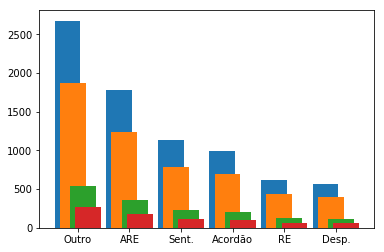

In [84]:
_, dump_train, dump_validation, dump_test = split_dataset(df_dump_free)
_

In [85]:
dump_train.to_csv('data/train-26-07-2018-wo-duplicates.csv', index=False)

dump_validation.to_csv('data/validation-26-07-2018-wo-duplicates.csv', index=False)

dump_test.to_csv('data/test-26-07-2018-wo-duplicates.csv', index=False)

array([[3424, 1274, 1128, 973, 615, 562, 59, 22],
       [2397, 892, 790, 681, 430, 393, 41, 15],
       [685, 255, 225, 195, 123, 113, 12, 5],
       [342, 127, 113, 97, 62, 56, 6, 2],
       ['Outro', 'ARE', 'Sent.', 'Acordao', 'RE', 'Desp.', 'P. Agrav',
        'D. Agrav']], dtype=object)

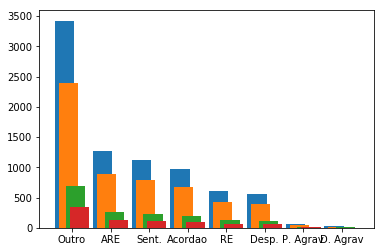

In [87]:
_, train, validation, test = split_dataset(df_free)
_

In [88]:
train.to_csv('data/train-27-06-2018-wo-duplicates.csv', index=False)

validation.to_csv('data/validation-27-06-2018-wo-duplicates.csv', index=False)

test.to_csv('data/test-27-06-2018-wo-duplicates.csv', index=False)

# Validation on Database to LegalLabs

In [2]:
# with ZipFile('/home/isis/Annotated_types.zip') as zip_dir:
#     df_test = pd.read_csv(zip_dir.open('test_types-26-07-18.csv'))
#     df_train = pd.read_csv(zip_dir.open('train_types-26-07-18.csv'))
# df = pd.concat([df_test, df_train])
# df.shape

In [3]:
# texts = df.progress_apply(page_split, axis=1).sort_values('document_id')
# texts.head()

In [4]:
# for idx, doc in texts[~texts.second_page.isnull()].iterrows():
#     print('############', idx, '#############\n', doc.first_page, '--------\n', doc.second_page)

In [5]:
# DSN = "dbname=postgres user=postgres host=toth.lades.unb.br"

In [6]:
# # pages.index = pdfs_documents.page_to - pdfs_documents.page_from
# QUERY = """
# SELECT documents.id as document_id, pages.index as page, pages.body as text FROM documents
#     INNER JOIN pages ON documents.id = pages.document_id
#     INNER JOIN pdfs_documents ON documents.id = pdfs_documents.document_id
#     WHERE (
#         (pages.body = %s AND pages.index = 0)
#         OR
#         (pages.body = %s AND pages.index = 1)
#     )
#     ORDER BY documents.id, pages.index;
# """

# docs = []
# with psycopg2.connect(DSN) as con:
#     with con.cursor() as cur:
#         for doc in tqdm(texts.apply(lambda x: (x.first_page, x.second_page), axis=1)):
#             query = cur.mogrify(QUERY, doc)
# #             df_sql = psql.read_sql(QUERY, con)
#             cur.execute(query)
#             for row in cur.fetchall():
#                 docs.append(row)

In [7]:
# # pd.DataFrame(docs, columns=['document_id', 'page', 'text']).to_csv('/home/isis/dump_pages.csv', index=False)
# docs = pd.read_csv('/home/isis/dump_pages.csv')
# docs

In [8]:
# def pages_to_columns(document):
#     unique_documents = document.drop_duplicates(['document_id', 'page'], keep='first')
#     pages = unique_documents.text.tolist()
#     if len(pages) == 1:
#         pages += [None]
#     elif len(pages) == 2:
#         pass
#     else:
#         print(pages)
#     return pd.Series(pages, index=['first_page', 'second_page'])

In [9]:
# ndocs = docs.groupby('document_id').progress_apply(pages_to_columns).reset_index()

# texts = df_dump_free.progress_apply(page_split, axis=1)

In [10]:
# display(ndocs.head())
# display(ndocs.shape)
# display(texts.head())
# display(texts.shape)

In [11]:
# texts[texts.first_page.isin(ndocs.first_page)]